# Issue with contiguity masking Sentinel-2 at 10m resolution

## Sample query

In [18]:
import odc.algo
import datacube 
import xarray as xr
import matplotlib.pyplot as plt

dc = datacube.Datacube()

# Jervis Bay
ymax, xmin = -35.089990, 150.681434
ymin, xmax = -35.141944, 150.734306

# Roebuck
ymax, xmin = -28.086443, 153.445244
ymin, xmax = -28.274374, 153.598194

query = {
    'x': (xmin, xmax),
    'y': (ymax, ymin),
    'time': ('2018', '2018-06'),
    'measurements': ['nbart_red', 'nbart_green', 'nbart_blue', 'fmask'],
    'output_crs': 'EPSG:32756',
    'group_by': 'solar_day'
}


## Load and preview data at 20m resolution

In [19]:
# Load data
ds = dc.load(product='s2b_ard_granule', 
             resolution=(-20, 20),
             **query)

## Create basic fmask mask

In [20]:
# ds.fmask.plot(col='time', col_wrap=4)

In [21]:
mask = odc.algo.fmask_to_bool(ds.fmask, categories=['valid', 'snow', 'water'])

In [22]:
# mask.plot(col='time', col_wrap=4)

## Create cleaned and buffered mask

In [23]:
from skimage.morphology import binary_erosion, binary_closing, disk

def cloud_buffer(da, radius=0, base_radius=10):

    # First remove small or narrow features using morphological closing
    mask_closing = binary_closing(da, disk(base_radius))
    
    # Then buffer remaining pixels by a radius to mask cloud edges
    mask_buffer = binary_erosion(mask_closing, disk(radius))
    
    return mask_buffer

new_mask = mask.groupby('time').apply(cloud_buffer)

In [24]:
# Compute median RGB and sum of good data through time
rgb_mask = ds.where(mask)[['nbart_red', 'nbart_green', 'nbart_blue']].median(dim='time')
rgb_new_mask = ds.where(new_mask)[['nbart_red', 'nbart_green', 'nbart_blue']].median(dim='time')
sum_mask = mask.sum(dim='time')
sum_new_mask = new_mask.sum(dim='time')

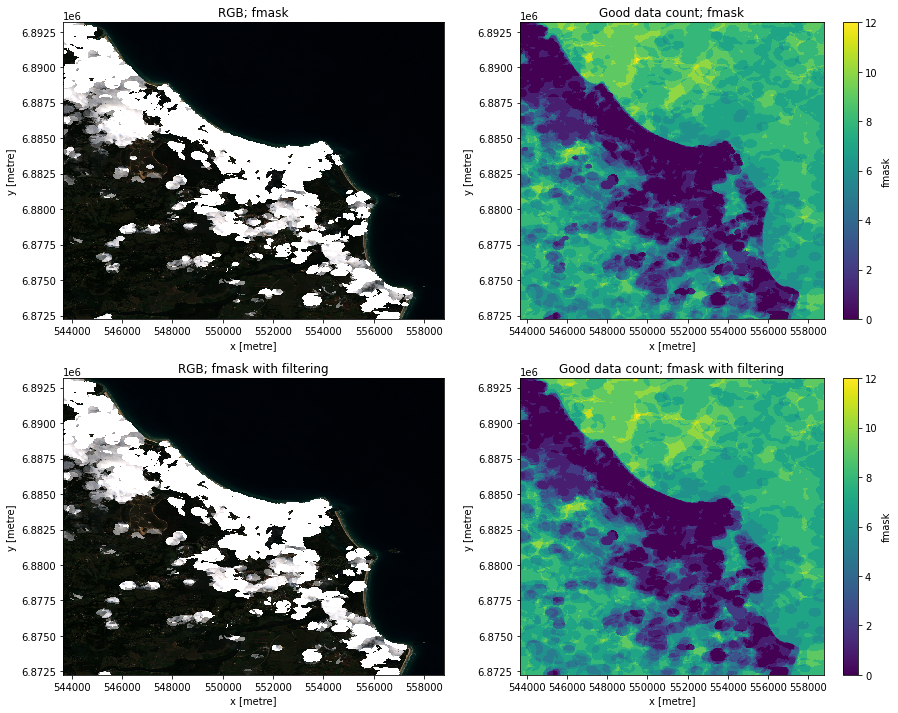

In [25]:
# Create four panel figure
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot median RGB composites into left column
rgb_mask.to_array().plot.imshow(robust=True, ax=axes[0, 0])
rgb_new_mask.to_array().plot.imshow(robust=True, ax=axes[1, 0])

# Calculate count stats and plot count arrays into right column
vmax = xr.concat([sum_mask.max(), sum_new_mask.max()], dim='time').max().item()
sum_mask.plot(vmin=0, vmax=vmax, ax=axes[0, 1])
sum_new_mask.plot(vmin=0, vmax=vmax, ax=axes[1, 1])

# Set titles
axes[0, 0].set_title("RGB; fmask")
axes[0, 1].set_title("Good data count; fmask")
axes[1, 0].set_title("RGB; fmask with filtering")
axes[1, 1].set_title("Good data count; fmask with filtering");